In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df=pd.read_csv('data/dow_30.csv', sep=",")
df['Date'] = pd.to_datetime(df['Date'])

#df.drop(index=1, inplace=True)
df.head(3)
df

Date        Open        High         Low       Close   Adj Close  \
0     2014-09-02   25.764999   25.934999   25.680000   25.825001   22.956745   
1     2014-09-03   25.775000   25.799999   24.645000   24.735001   21.987814   
2     2014-09-04   24.712500   25.022499   24.447500   24.530001   21.805574   
3     2014-09-05   24.700001   24.847500   24.577499   24.742500   21.994478   
4     2014-09-08   24.825001   24.827499   24.512501   24.590000   21.858908   
...          ...         ...         ...         ...         ...         ...   
72171 2024-05-10  118.540001  118.660004  117.580002  117.959999  117.009598   
72172 2024-05-13  118.419998  119.040001  117.120003  117.910004  116.960007   
72173 2024-05-14  116.790001  117.739998  116.480003  117.669998  117.669998   
72174 2024-05-15  117.610001  118.839996  116.080002  118.580002  118.580002   
72175 2024-05-16  118.540001  119.300003  117.540001  117.870003  117.870003   

       Volume($) Symbol  Daily Return  
0      214256000   AAPL           NaN  
1      501684000   AAPL     -0.042207  
2      342872000   AAPL     -0.008288  
3      233828000   AAPL      0.008663  
4      185426800   AAPL     -0.006163  
...          ...    ...           ...  
72171   13648100    XOM     -0.004053  
72172   15060600    XOM     -0.000424  
72173   15079100    XOM     -0.002035  
72174   18244300    XOM      0.007734  
72175   15745200    XOM     -0.005988  

[72176 rows x 9 columns]

In [71]:
# Moving Averages
df['SMA_30'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=30).mean())
df['SMA_60'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=60).mean())
df['SMA_90'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=90).mean())

df['EMA_30'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=30, adjust=False).mean())
df['EMA_60'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=60, adjust=False).mean())
df['EMA_90'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=90, adjust=False).mean())

# RSI Calculation (Relative Strength Index)
def calculate_rsi(x, periods=14):
    delta = x.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = df.groupby('Symbol')['Close'].transform(calculate_rsi)

# MACD Calculation (Moving Average Convergence Divergence, which essentially prioritizes the latest stock price while taking into account previous stock price)
df['EMA_12'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
df['EMA_26'] = df.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']


#### 30, 60, 90 Moving Average

In [72]:
#  Moving Averages for the Closing Prices of each stock
df['30_day_MA'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=30).mean())
df['60_day_MA'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=60).mean())
df['90_day_MA'] = df.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=90).mean())

#### 30-Day Rolling Volatility 

In [73]:

# Assuming df is your DataFrame and it's already loaded

# Calculate log returns
df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# Calculate 30-day rolling volatility for each stock
symbols = df['Symbol'].unique()
for symbol in symbols:
    symbol_log_returns = df[df['Symbol'] == symbol]['Log_Return']
    df.loc[df['Symbol'] == symbol, 'Rolling_Volatility'] = symbol_log_returns.rolling(window=30).std() * np.sqrt(252)

# Pivot the DataFrame to get a date index and separate columns for each stock's volatility
volatility_df = df.pivot_table(index='Date', columns='Symbol', values='Rolling_Volatility', aggfunc='first')



In [74]:
import plotly.graph_objects as go

# Create a plotly figure
fig = go.Figure()

# Add a line for each stock
for symbol in symbols:
    fig.add_trace(go.Scatter(x=volatility_df.index, y=volatility_df[symbol], mode='lines', name=symbol))

# Update layout for better visualization
fig.update_layout(
    title='30-Day Rolling Volatility for All Stocks',
    xaxis_title='Date',
    yaxis_title='Annualized Volatility (Log Scale)',
    yaxis_type="log",  # Set the y-axis to log scale
    legend_title='Stock Symbol',
    template='plotly_white'
)

# Show the figure
fig.show()


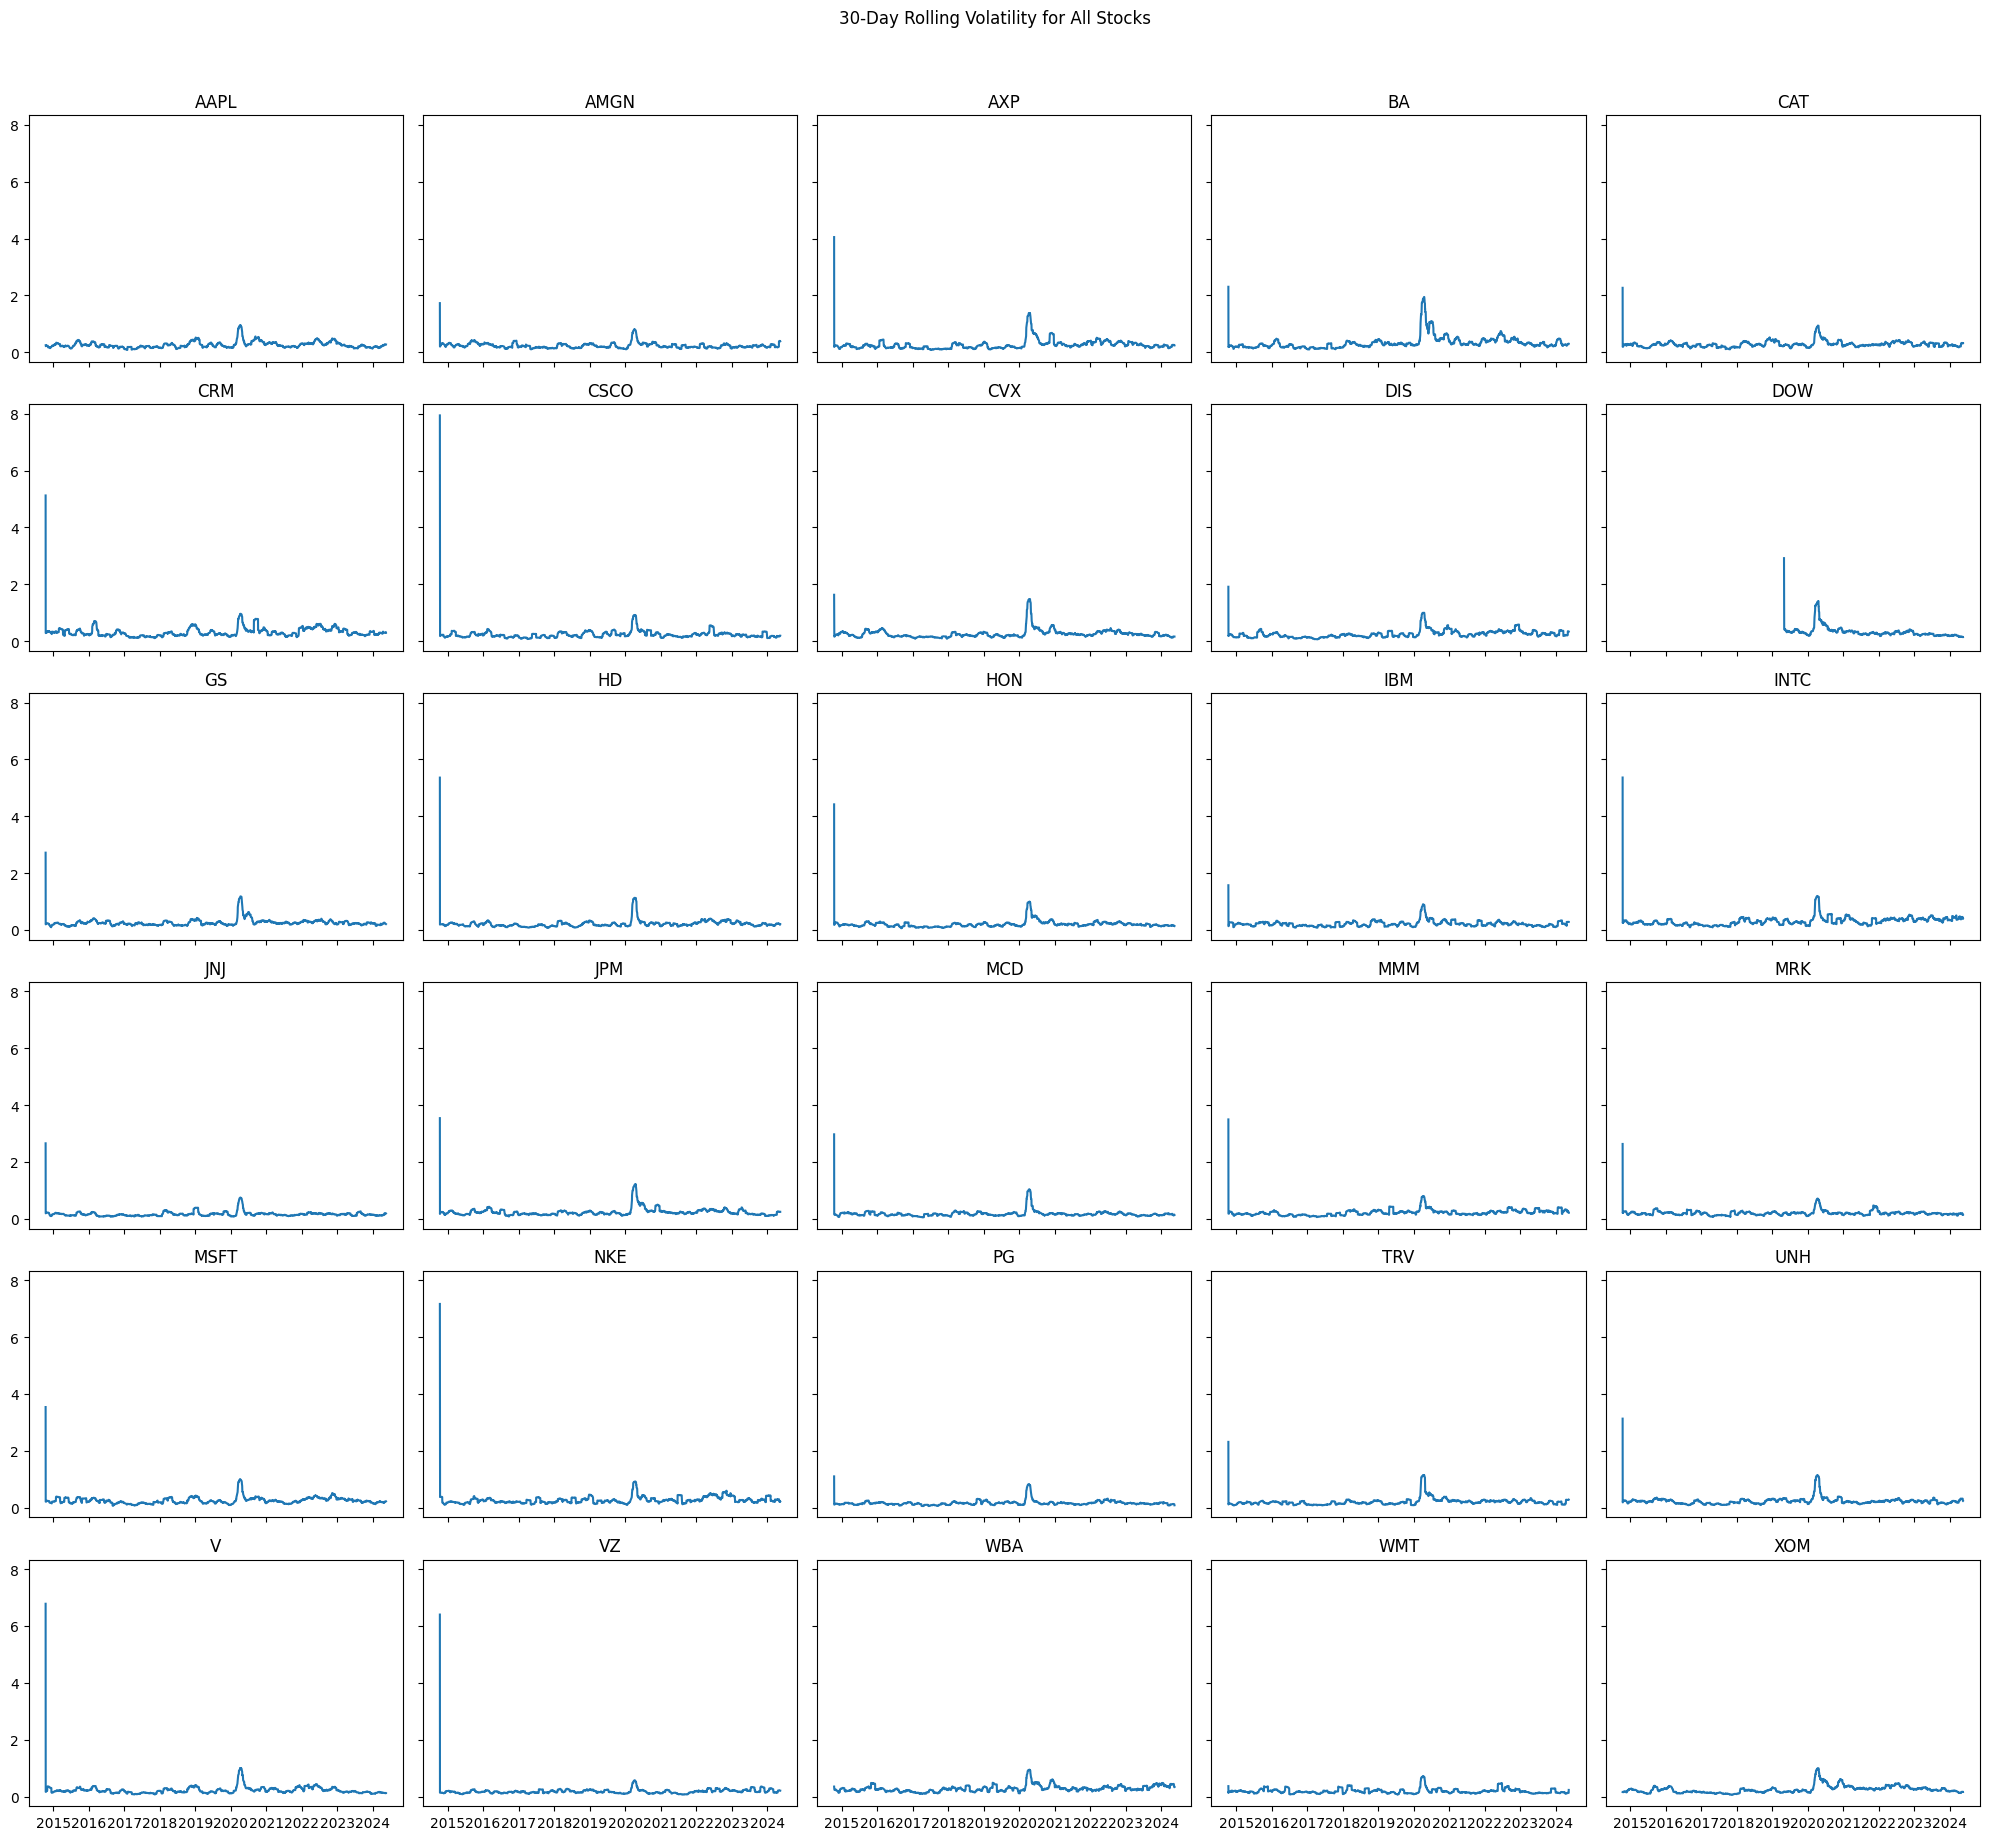

In [75]:


# Determine number of rows and columns for subplots
num_stocks = len(symbols)
num_cols = 5
num_rows = num_stocks // num_cols + (num_stocks % num_cols > 0)

# Create a grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, symbol in enumerate(symbols):
    sns.lineplot(x=volatility_df.index, y=volatility_df[symbol], ax=axes[i])
    axes[i].set_title(symbol)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

fig.suptitle('30-Day Rolling Volatility for All Stocks', y=1.02)
plt.tight_layout()
plt.show()


In [76]:

AAPL_log_returns = df[df['Symbol'] == 'AAPL']['Log_Return']
XOM_log_returns = df[df['Symbol'] == 'XOM']['Log_Return']

df.loc[df['Symbol'] == 'AAPL', 'AAPL_Volatility'] = AAPL_log_returns.rolling(window=30).std() * np.sqrt(252)
df.loc[df['Symbol'] == 'XOM', 'XOM_Volatility'] = XOM_log_returns.rolling(window=30).std() * np.sqrt(252)


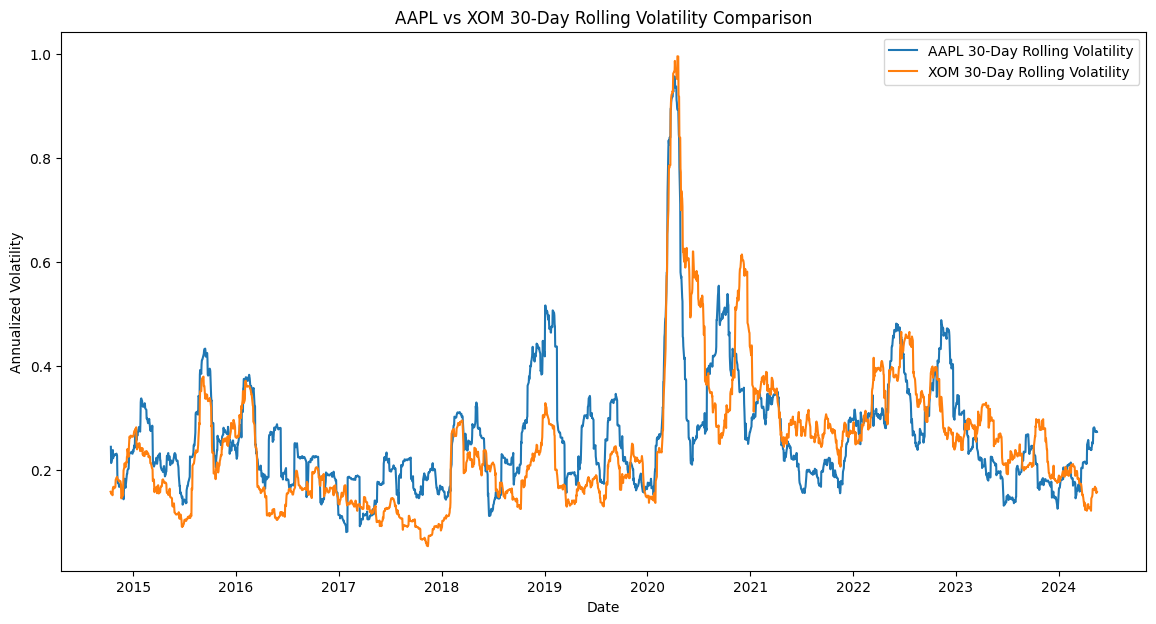

In [77]:
# Pivot the DataFrame to get a date index and separate columns for BTC and ETH volatility
volatility_df = df.pivot_table(index='Date', values=['AAPL_Volatility', 'XOM_Volatility'], aggfunc='first')


plt.figure(figsize=(14, 7))
plt.plot(volatility_df['AAPL_Volatility'], label='AAPL 30-Day Rolling Volatility')
plt.plot(volatility_df['XOM_Volatility'], label='XOM 30-Day Rolling Volatility')
plt.title('AAPL vs XOM 30-Day Rolling Volatility Comparison')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.show()


In [78]:
df.isnull().sum()


Date                      0
Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume($)                 0
Symbol                    0
Daily Return             30
SMA_30                  870
SMA_60                 1770
SMA_90                 2670
EMA_30                    0
EMA_60                    0
EMA_90                    0
RSI                     390
EMA_12                    0
EMA_26                    0
MACD                      0
Signal_Line               0
MACD_Histogram            0
30_day_MA               870
60_day_MA              1770
90_day_MA              2670
Log_Return                1
Rolling_Volatility      871
AAPL_Volatility       69762
XOM_Volatility        69761
dtype: int64

#### Creating Lag Features

Created by shifting the values of a given feature backwards in time. This process introduces previous time steps of a feature as input for predictions, allowing models to learn from past values to predict future ones. For cryptocurrencies, lag features of prices and volumes can be particularly informative.

In [79]:
# Creating lag features for 'Close' and 'Volume($)'
for lag in [1, 3, 7]:
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    df[f'Volume_lag_{lag}'] = df['Volume($)'].shift(lag)

# Generating rolling window features for 'Close' and 'Volume($)'
for window in [7, 30]:
    df[f'Close_rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'Close_rolling_std_{window}'] = df['Close'].rolling(window=window).std()
    df[f'Volume_rolling_mean_{window}'] = df['Volume($)'].rolling(window=window).mean()
    df[f'Volume_rolling_std_{window}'] = df['Volume($)'].rolling(window=window).std()

df.head()

Date       Open       High        Low      Close  Adj Close  \
0 2014-09-02  25.764999  25.934999  25.680000  25.825001  22.956745   
1 2014-09-03  25.775000  25.799999  24.645000  24.735001  21.987814   
2 2014-09-04  24.712500  25.022499  24.447500  24.530001  21.805574   
3 2014-09-05  24.700001  24.847500  24.577499  24.742500  21.994478   
4 2014-09-08  24.825001  24.827499  24.512501  24.590000  21.858908   

   Volume($) Symbol  Daily Return  SMA_30  ...  Close_lag_7  Volume_lag_7  \
0  214256000   AAPL           NaN     NaN  ...          NaN           NaN   
1  501684000   AAPL     -0.042207     NaN  ...          NaN           NaN   
2  342872000   AAPL     -0.008288     NaN  ...          NaN           NaN   
3  233828000   AAPL      0.008663     NaN  ...          NaN           NaN   
4  185426800   AAPL     -0.006163     NaN  ...          NaN           NaN   

   Close_rolling_mean_7  Close_rolling_std_7  Volume_rolling_mean_7  \
0                   NaN                  NaN                    NaN   
1                   NaN                  NaN                    NaN   
2                   NaN                  NaN                    NaN   
3                   NaN                  NaN                    NaN   
4                   NaN                  NaN                    NaN   

   Volume_rolling_std_7  Close_rolling_mean_30  Close_rolling_std_30  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                   NaN                    NaN                   NaN   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   

   Volume_rolling_mean_30  Volume_rolling_std_30  
0                     NaN                    NaN  
1                     NaN                    NaN  
2                     NaN                    NaN  
3                     NaN                    NaN  
4                     NaN                    NaN  

[5 rows x 42 columns]

In [80]:
df

Date        Open        High         Low       Close   Adj Close  \
0     2014-09-02   25.764999   25.934999   25.680000   25.825001   22.956745   
1     2014-09-03   25.775000   25.799999   24.645000   24.735001   21.987814   
2     2014-09-04   24.712500   25.022499   24.447500   24.530001   21.805574   
3     2014-09-05   24.700001   24.847500   24.577499   24.742500   21.994478   
4     2014-09-08   24.825001   24.827499   24.512501   24.590000   21.858908   
...          ...         ...         ...         ...         ...         ...   
72171 2024-05-10  118.540001  118.660004  117.580002  117.959999  117.009598   
72172 2024-05-13  118.419998  119.040001  117.120003  117.910004  116.960007   
72173 2024-05-14  116.790001  117.739998  116.480003  117.669998  117.669998   
72174 2024-05-15  117.610001  118.839996  116.080002  118.580002  118.580002   
72175 2024-05-16  118.540001  119.300003  117.540001  117.870003  117.870003   

       Volume($) Symbol  Daily Return      SMA_30  ...  Close_lag_7  \
0      214256000   AAPL           NaN         NaN  ...          NaN   
1      501684000   AAPL     -0.042207         NaN  ...          NaN   
2      342872000   AAPL     -0.008288         NaN  ...          NaN   
3      233828000   AAPL      0.008663         NaN  ...          NaN   
4      185426800   AAPL     -0.006163         NaN  ...          NaN   
...          ...    ...           ...         ...  ...          ...   
72171   13648100    XOM     -0.004053  119.057667  ...   116.029999   
72172   15060600    XOM     -0.000424  119.088333  ...   116.239998   
72173   15079100    XOM     -0.002035  119.034667  ...   116.000000   
72174   18244300    XOM      0.007734  119.010667  ...   116.750000   
72175   15745200    XOM     -0.005988  118.949000  ...   116.169998   

       Volume_lag_7  Close_rolling_mean_7  Close_rolling_std_7  \
0               NaN                   NaN                  NaN   
1               NaN                   NaN                  NaN   
2               NaN                   NaN                  NaN   
3               NaN                   NaN                  NaN   
4               NaN                   NaN                  NaN   
...             ...                   ...                  ...   
72171    27777700.0            116.815714             0.983953   
72172    25513600.0            117.054286             1.022789   
72173    28023300.0            117.292858             0.926081   
72174    31401300.0            117.554286             1.002445   
72175    30122000.0            117.797144             0.795817   

       Volume_rolling_mean_7  Volume_rolling_std_7  Close_rolling_mean_30  \
0                        NaN                   NaN                    NaN   
1                        NaN                   NaN                    NaN   
2                        NaN                   NaN                    NaN   
3                        NaN                   NaN                    NaN   
4                        NaN                   NaN                    NaN   
...                      ...                   ...                    ...   
72171           2.360421e+07          6.875722e+06             119.057667   
72172           2.211093e+07          7.498795e+06             119.088333   
72173           2.026176e+07          7.393082e+06             119.034667   
72174           1.838219e+07          5.525655e+06             119.010667   
72175           1.632836e+07          1.949366e+06             118.949000   

       Close_rolling_std_30  Volume_rolling_mean_30  Volume_rolling_std_30  
0                       NaN                     NaN                    NaN  
1                       NaN                     NaN                    NaN  
2                       NaN                     NaN                    NaN  
3                       NaN                     NaN                    NaN  
4                       NaN                     NaN                    NaN  
...               

In [81]:
# Drop the initial rows where rolling features cannot be computed (first 30 days due to the longest window)
#df = df.dropna()


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72176 entries, 0 to 72175
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    72176 non-null  datetime64[ns]
 1   Open                    72176 non-null  float64       
 2   High                    72176 non-null  float64       
 3   Low                     72176 non-null  float64       
 4   Close                   72176 non-null  float64       
 5   Adj Close               72176 non-null  float64       
 6   Volume($)               72176 non-null  int64         
 7   Symbol                  72176 non-null  object        
 8   Daily Return            72146 non-null  float64       
 9   SMA_30                  71306 non-null  float64       
 10  SMA_60                  70406 non-null  float64       
 11  SMA_90                  69506 non-null  float64       
 12  EMA_30                  72176 non-null  float6

In [83]:
# Convert the Date column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Extract year, month, and day as separate features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df = df.drop('Date', axis=1)


In [84]:
def nulls_summary_table(df):
    """
    Returns a summary table showing null value counts and percentage

    Parameters:
    df (DataFrame): Dataframe to check

    Returns:
    
    null_values (DataFrame)
    """
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count','null_pct']
    return null_values

nulls_summary_table(df)

null_count  null_pct
Open                             0  0.000000
High                             0  0.000000
Low                              0  0.000000
Close                            0  0.000000
Adj Close                        0  0.000000
Volume($)                        0  0.000000
Symbol                           0  0.000000
Daily Return                    30  0.000416
SMA_30                         870  0.012054
SMA_60                        1770  0.024523
SMA_90                        2670  0.036993
EMA_30                           0  0.000000
EMA_60                           0  0.000000
EMA_90                           0  0.000000
RSI                            390  0.005403
EMA_12                           0  0.000000
EMA_26                           0  0.000000
MACD                             0  0.000000
Signal_Line                      0  0.000000
MACD_Histogram                   0  0.000000
30_day_MA                      870  0.012054
60_day_MA                     1770  0.024523
90_day_MA                     2670  0.036993
Log_Return                       1  0.000014
Rolling_Volatility             871  0.012068
AAPL_Volatility              69762  0.966554
XOM_Volatility               69761  0.966540
Close_lag_1                      1  0.000014
Volume_lag_1                     1  0.000014
Close_lag_3                      3  0.000042
Volume_lag_3                     3  0.000042
Close_lag_7                      7  0.000097
Volume_lag_7                     7  0.000097
Close_rolling_mean_7             6  0.000083
Close_rolling_std_7              6  0.000083
Volume_rolling_mean_7            6  0.000083
Volume_rolling_std_7             6  0.000083
Close_rolling_mean_30           29  0.000402
Close_rolling_std_30            29  0.000402
Volume_rolling_mean_30          29  0.000402
Volume_rolling_std_30           29  0.000402
Year                             0  0.000000
Month                            0  0.000000
Day                              0  0.000000

In [85]:
df.to_csv('data/df_fe.csv', index=False)